In [1]:
# Import necessary libraries

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import re
import os

/opt/anaconda3/envs/ai_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and preprocess Yelp dataset with aspect tagging only (no translation)
def load_dataset_yelp():
    # Load CSV and select relevant columns
    df = pd.read_csv("yelp_academic_dataset_review.csv")
    df = df[['text', 'label']].dropna()

    # Extract simple aspect labels from the text
    def extract_aspects(text):
        aspects = []
        if re.search(r'food|taste|meal|menu|dish', text, re.IGNORECASE):
            aspects.append("Food")
        if re.search(r'service|waiter|staff|employee', text, re.IGNORECASE):
            aspects.append("Service")
        if re.search(r'price|cost|value|expensive|cheap', text, re.IGNORECASE):
            aspects.append("Price")
        if re.search(r'clean|hygiene|environment|atmosphere', text, re.IGNORECASE):
            aspects.append("Ambience")
        return ", ".join(aspects) if aspects else "General"

    df['aspects'] = df['text'].apply(extract_aspects)
    df = df[['text', 'label', 'aspects']]
    dataset = Dataset.from_pandas(df)
    return dataset.train_test_split(test_size=0.2)

In [3]:
# Compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

In [4]:
# Fine-tune BERT model on the dataset
def train_bert_model(dataset):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def tokenize(example):
        return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

    tokenized_datasets = dataset.map(tokenize, batched=True)
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        logging_dir="./logs",
        gradient_accumulation_steps=2,

    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        compute_metrics=compute_metrics
    )
    trainer.train()

    # Save model artifacts
    model.save_pretrained("./trained_model")
    tokenizer.save_pretrained("./trained_model")
    torch.save(model.state_dict(), "model_weights.pth")

    return model, tokenizer

# Run script
if __name__ == "__main__":
    dataset = load_dataset_yelp()
    model, tokenizer = train_bert_model(dataset)

Map: 100%|██████████| 2000/2000 [00:02<00:00, 872.54 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|█████     | 500/1000 [11:33:10<9:27:04, 68.05s/it] 

{'loss': 0.6117, 'grad_norm': 6.245513916015625, 'learning_rate': 2.5e-05, 'epoch': 1.0}


                                                       
 50%|█████     | 500/1000 [11:34:46<9:27:04, 68.05s/it]

{'eval_loss': 0.5386298298835754, 'eval_accuracy': 0.777, 'eval_f1': 0.7768781099060905, 'eval_runtime': 96.6224, 'eval_samples_per_second': 20.699, 'eval_steps_per_second': 2.587, 'epoch': 1.0}


100%|██████████| 1000/1000 [23:01:24<00:00, 133.39s/it]  

{'loss': 0.3437, 'grad_norm': 5.135979175567627, 'learning_rate': 0.0, 'epoch': 2.0}


                                                       
100%|██████████| 1000/1000 [23:03:31<00:00, 133.39s/it]

{'eval_loss': 0.5395463705062866, 'eval_accuracy': 0.796, 'eval_f1': 0.7966597668651503, 'eval_runtime': 126.1268, 'eval_samples_per_second': 15.857, 'eval_steps_per_second': 1.982, 'epoch': 2.0}


100%|██████████| 1000/1000 [23:03:37<00:00, 83.02s/it] 


{'train_runtime': 83017.9396, 'train_samples_per_second': 0.193, 'train_steps_per_second': 0.012, 'train_loss': 0.47767709350585935, 'epoch': 2.0}


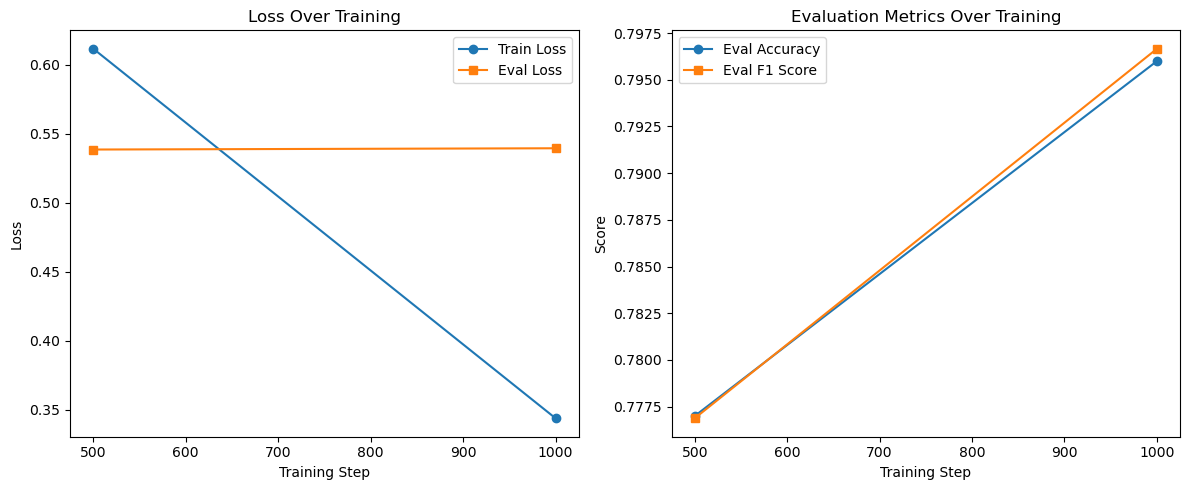

In [17]:
import matplotlib.pyplot as plt

# Extracted from your trainer_state.json
log_history = [
    {"epoch": 1.0, "grad_norm": 6.245513916015625, "learning_rate": 2.5e-05, "loss": 0.6117, "step": 500},
    {"epoch": 1.0, "eval_accuracy": 0.777, "eval_f1": 0.7768781099060905, "eval_loss": 0.5386298298835754, "eval_runtime": 96.6224, "eval_samples_per_second": 20.699, "eval_steps_per_second": 2.587, "step": 500},
    {"epoch": 2.0, "grad_norm": 5.135979175567627, "learning_rate": 0.0, "loss": 0.3437, "step": 1000},
    {"epoch": 2.0, "eval_accuracy": 0.796, "eval_f1": 0.7966597668651503, "eval_loss": 0.5395463705062866, "eval_runtime": 126.1268, "eval_samples_per_second": 15.857, "eval_steps_per_second": 1.982, "step": 1000}
]

train_loss = [log["loss"] for log in log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
eval_accuracy = [log["eval_accuracy"] for log in log_history if "eval_accuracy" in log]
eval_f1 = [log["eval_f1"] for log in log_history if "eval_f1" in log]
steps = [log["step"] for log in log_history if "eval_loss" in log]

# 📈 Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([500, 1000], train_loss, marker='o', label="Train Loss")
plt.plot(steps, eval_loss, marker='s', label="Eval Loss")
plt.title("Loss Over Training")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, eval_accuracy, marker='o', label="Eval Accuracy")
plt.plot(steps, eval_f1, marker='s', label="Eval F1 Score")
plt.title("Evaluation Metrics Over Training")
plt.xlabel("Training Step")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/n3/jxm0__sj5tq8qfdbvml472dh0000gn/T/ipykernel_15681/3052032315.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via

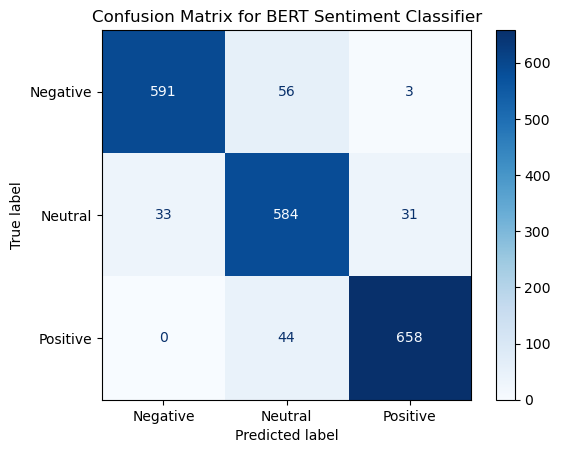


Classification Report:

              precision    recall  f1-score   support

    Negative       0.95      0.91      0.93       650
     Neutral       0.85      0.90      0.88       648
    Positive       0.95      0.94      0.94       702

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [20]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# === STEP 1: Load Dataset ===
df = pd.read_csv("yelp_academic_dataset_review.csv")
df = df[['text', 'label']].dropna()
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)
test_dataset = dataset["test"]

# === STEP 2: Load Tokenizer and Model ===
tokenizer = BertTokenizer.from_pretrained("./trained_model")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.load_state_dict(torch.load("model_weights.pth", map_location=device))
model.to(device)
model.eval()

# === STEP 3: Tokenize Test Set ===
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

tokenized = test_dataset.map(tokenize, batched=True)
tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask'])
true_labels = test_dataset['label']

# === STEP 4: Run Batch Predictions ===
all_preds = []
batch_size = 32

for i in range(0, len(tokenized), batch_size):
    batch = {
        "input_ids": tokenized["input_ids"][i:i+batch_size].to(device),
        "attention_mask": tokenized["attention_mask"][i:i+batch_size].to(device)
    }
    with torch.no_grad():
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

# === STEP 5: Plot Confusion Matrix and Print Classification Report ===
cm = confusion_matrix(true_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for BERT Sentiment Classifier")
plt.show()

print("\nClassification Report:\n")
print(classification_report(true_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))


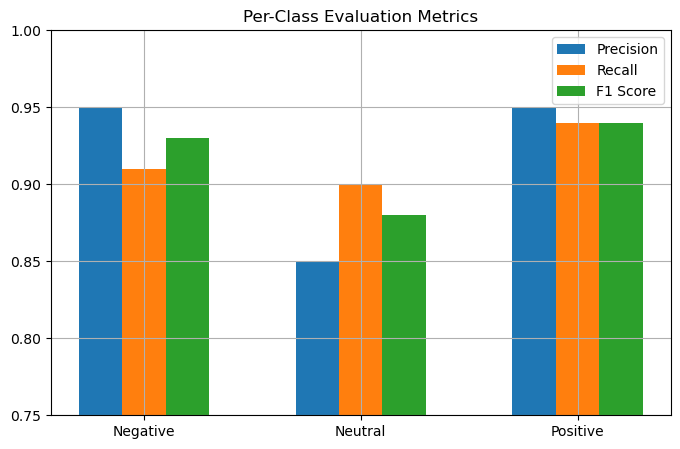

In [ ]:
# Visualization of per-class evaluation metrics

import matplotlib.pyplot as plt

labels = ['Negative', 'Neutral', 'Positive']
precision = [0.95, 0.85, 0.95]
recall = [0.91, 0.90, 0.94]
f1 = [0.93, 0.88, 0.94]

x = range(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, precision, width=0.2, label='Precision', align='center')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall', align='center')
plt.bar([i + 0.4 for i in x], f1, width=0.2, label='F1 Score', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylim(0.75, 1.0)
plt.title("Per-Class Evaluation Metrics")
plt.legend()
plt.grid(True)
plt.show()
